In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00


In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
data = pd.read_csv('/content/Microsoft_Stock.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
data.shape

(1511, 6)

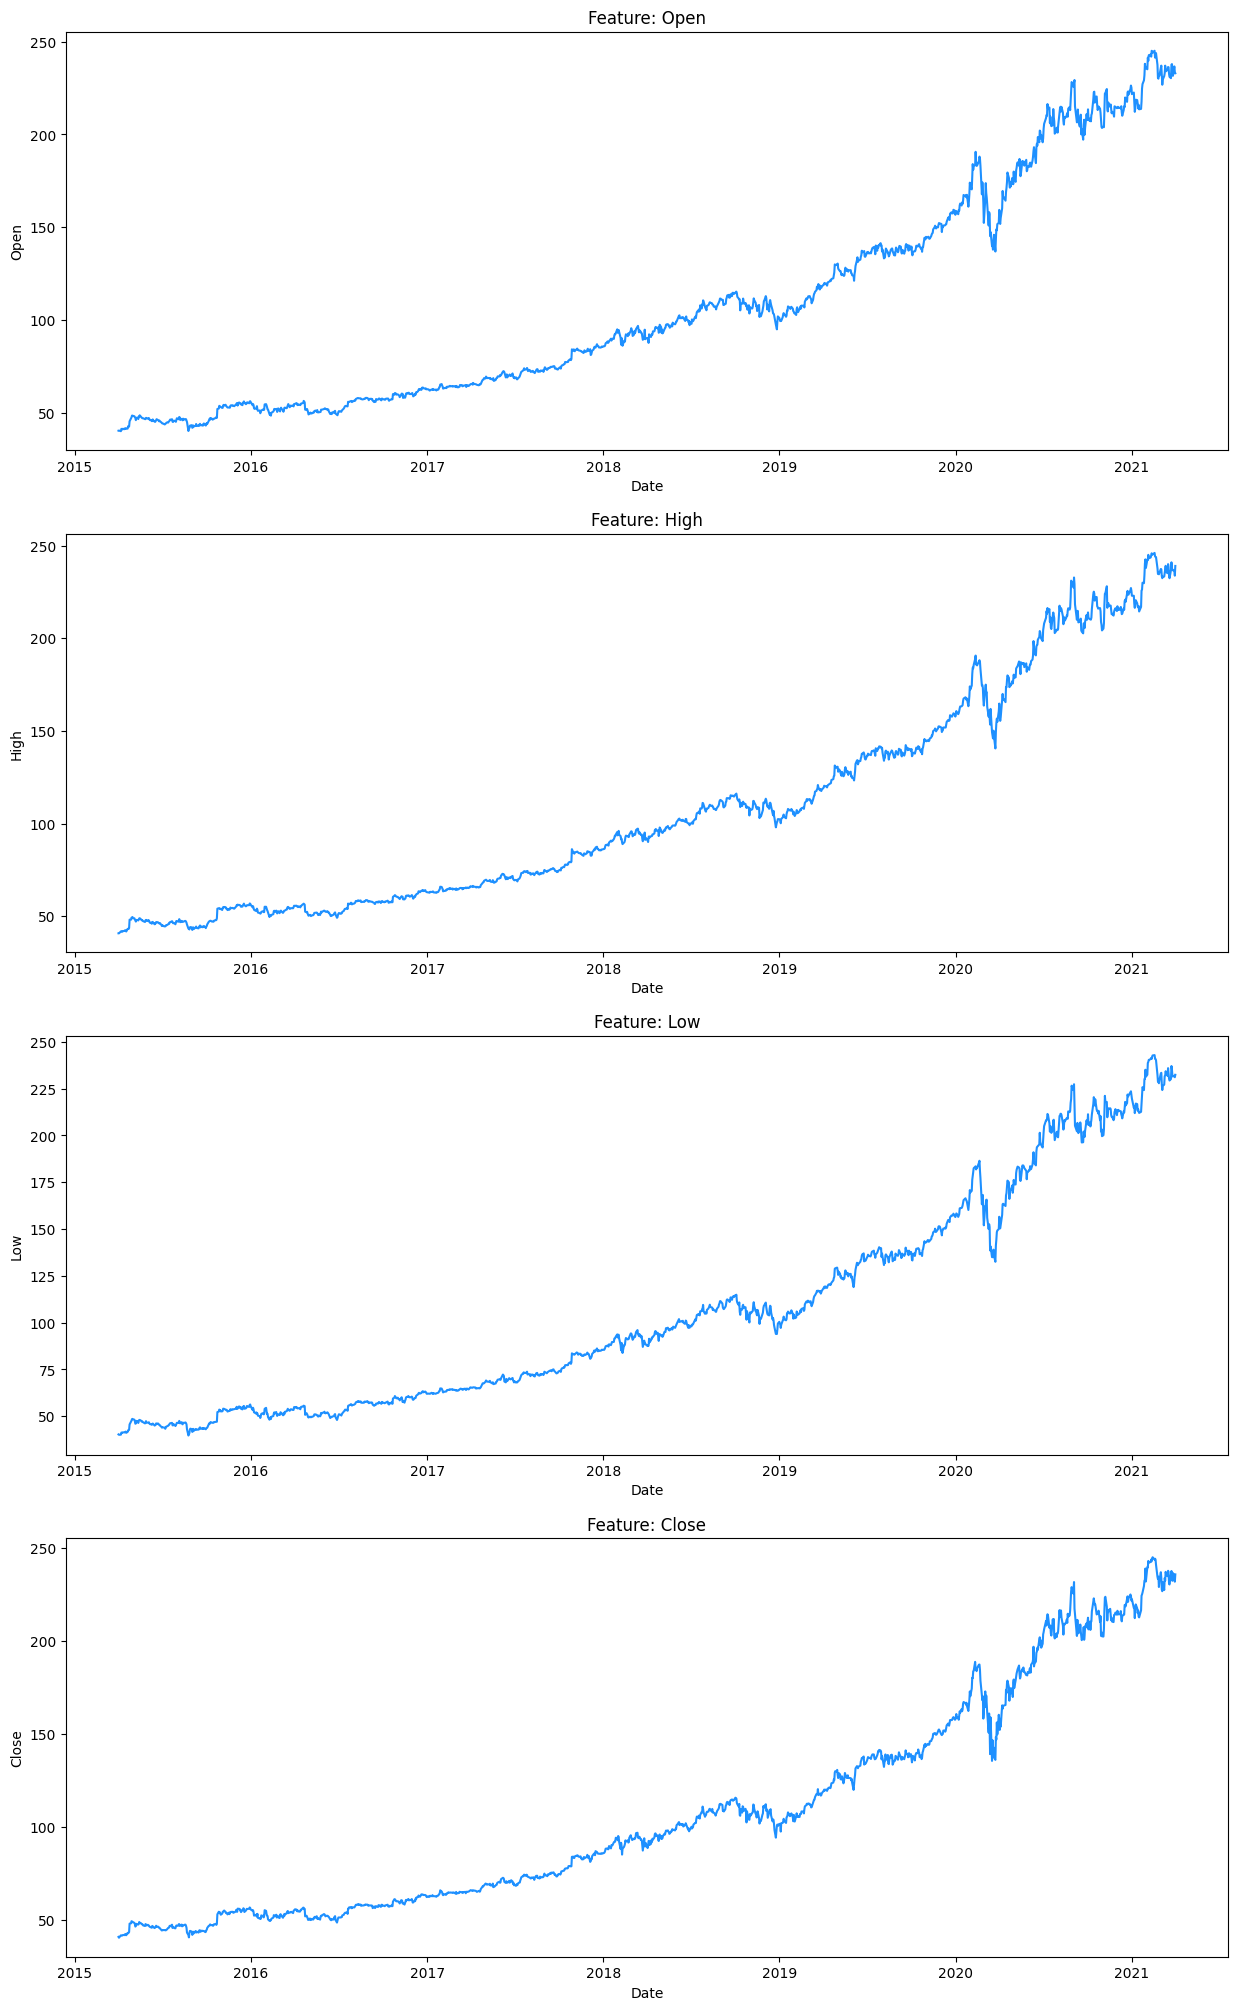

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,25))

for i, column in enumerate(data.drop(['Date', 'Volume'], axis=1).columns):
  sns.lineplot(x=data['Date'], y=data[column], ax=ax[i], color='dodgerblue')
  ax[i].set_title('Feature: {}'.format(column))


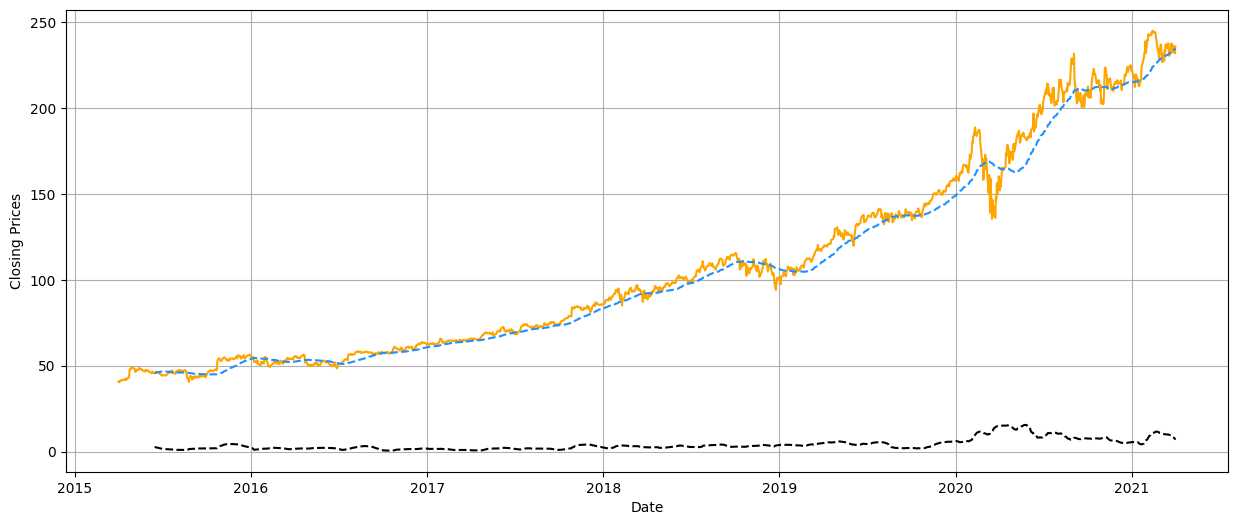

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=data['Date'], y=data['Close'], color='orange')
sns.lineplot(x=data['Date'], y=data['Close'].rolling(52).mean(), color='dodgerblue', linestyle='--')
sns.lineplot(x=data['Date'], y=data['Close'].rolling(52).std(), color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.grid(True)
plt.show()

In [ ]:
def calc_adfuller(column_name):
  result = adfuller(column_name.values)

  adf_statistic = result[0]
  p_value = result[1]
  lags_used = result[2]
  n_obs = result[3]
  critical_values = result[4]

  print(f"Adf Statistic: {adf_statistic}")
  print(f"P-Value: {p_value}")
  print(f"Lags Used: {lags_used}")
  print(f"Number of Observations: {n_obs}")
  print(f"Critical Values: {critical_values}")

In [ ]:
calc_adfuller(data['Close'])

Adf Statistic: 1.7371362899270975
P-Value: 0.9982158366942122
Lags Used: 24
Number of Observations: 1486
Critical Values: {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}


In [ ]:
ts_diff = np.diff(data['Close'])
data['Close_diff_1'] = np.append([0], ts_diff)

In [ ]:
calc_adfuller(data['Close_diff_1'])

Adf Statistic: -10.043852364231798
P-Value: 1.472030729039075e-17
Lags Used: 24
Number of Observations: 1486
Critical Values: {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}


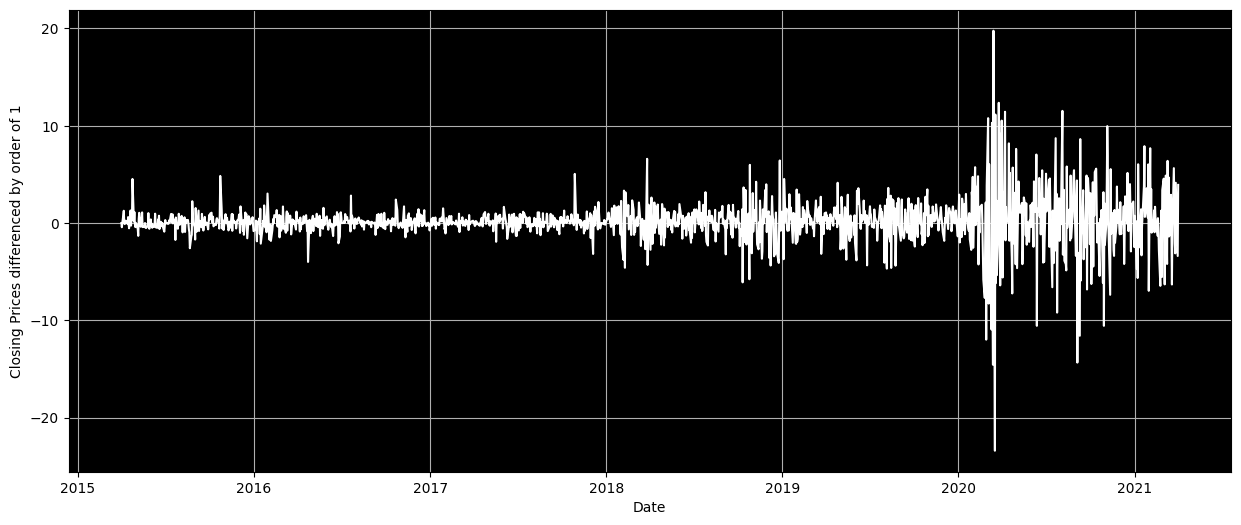

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=data['Date'], y=data['Close_diff_1'], color='white', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Closing Prices differenced by order of 1')
plt.grid(True)
plt.gca().set_facecolor('black')
plt.show()

In [ ]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['day'] = pd.DatetimeIndex(data['Date']).day
data['day_of_year'] = pd.DatetimeIndex(data['Date']).dayofyear
data['week_of_year'] = pd.DatetimeIndex(data['Date']).weekofyear
data['quarter'] = pd.DatetimeIndex(data['Date']).quarter
data['season'] = data['month'] % 12 // 3 + 1

data[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

<ipython-input-15-0313097bb1fc>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week_of_year'] = pd.DatetimeIndex(data['Date']).weekofyear


,Date,year,month,day,day_of_year,week_of_year,quarter,season
0,2015-04-01 16:00:00,2015,4,1,91,14,2,2
1,2015-04-02 16:00:00,2015,4,2,92,14,2,2
2,2015-04-06 16:00:00,2015,4,6,96,15,2,2
3,2015-04-07 16:00:00,2015,4,7,97,15,2,2
4,2015-04-08 16:00:00,2015,4,8,98,15,2,2


In [ ]:
data.head()

,Date,Open,High,Low,Close,Volume,Close_diff_1,year,month,day,day_of_year,week_of_year,quarter,season
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322,0.00,2015,4,1,91,14,2,2
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476,-0.43,2015,4,2,92,14,2,2
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692,1.26,2015,4,6,96,15,2,2
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375,-0.02,2015,4,7,97,15,2,2
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438,-0.11,2015,4,8,98,15,2,2


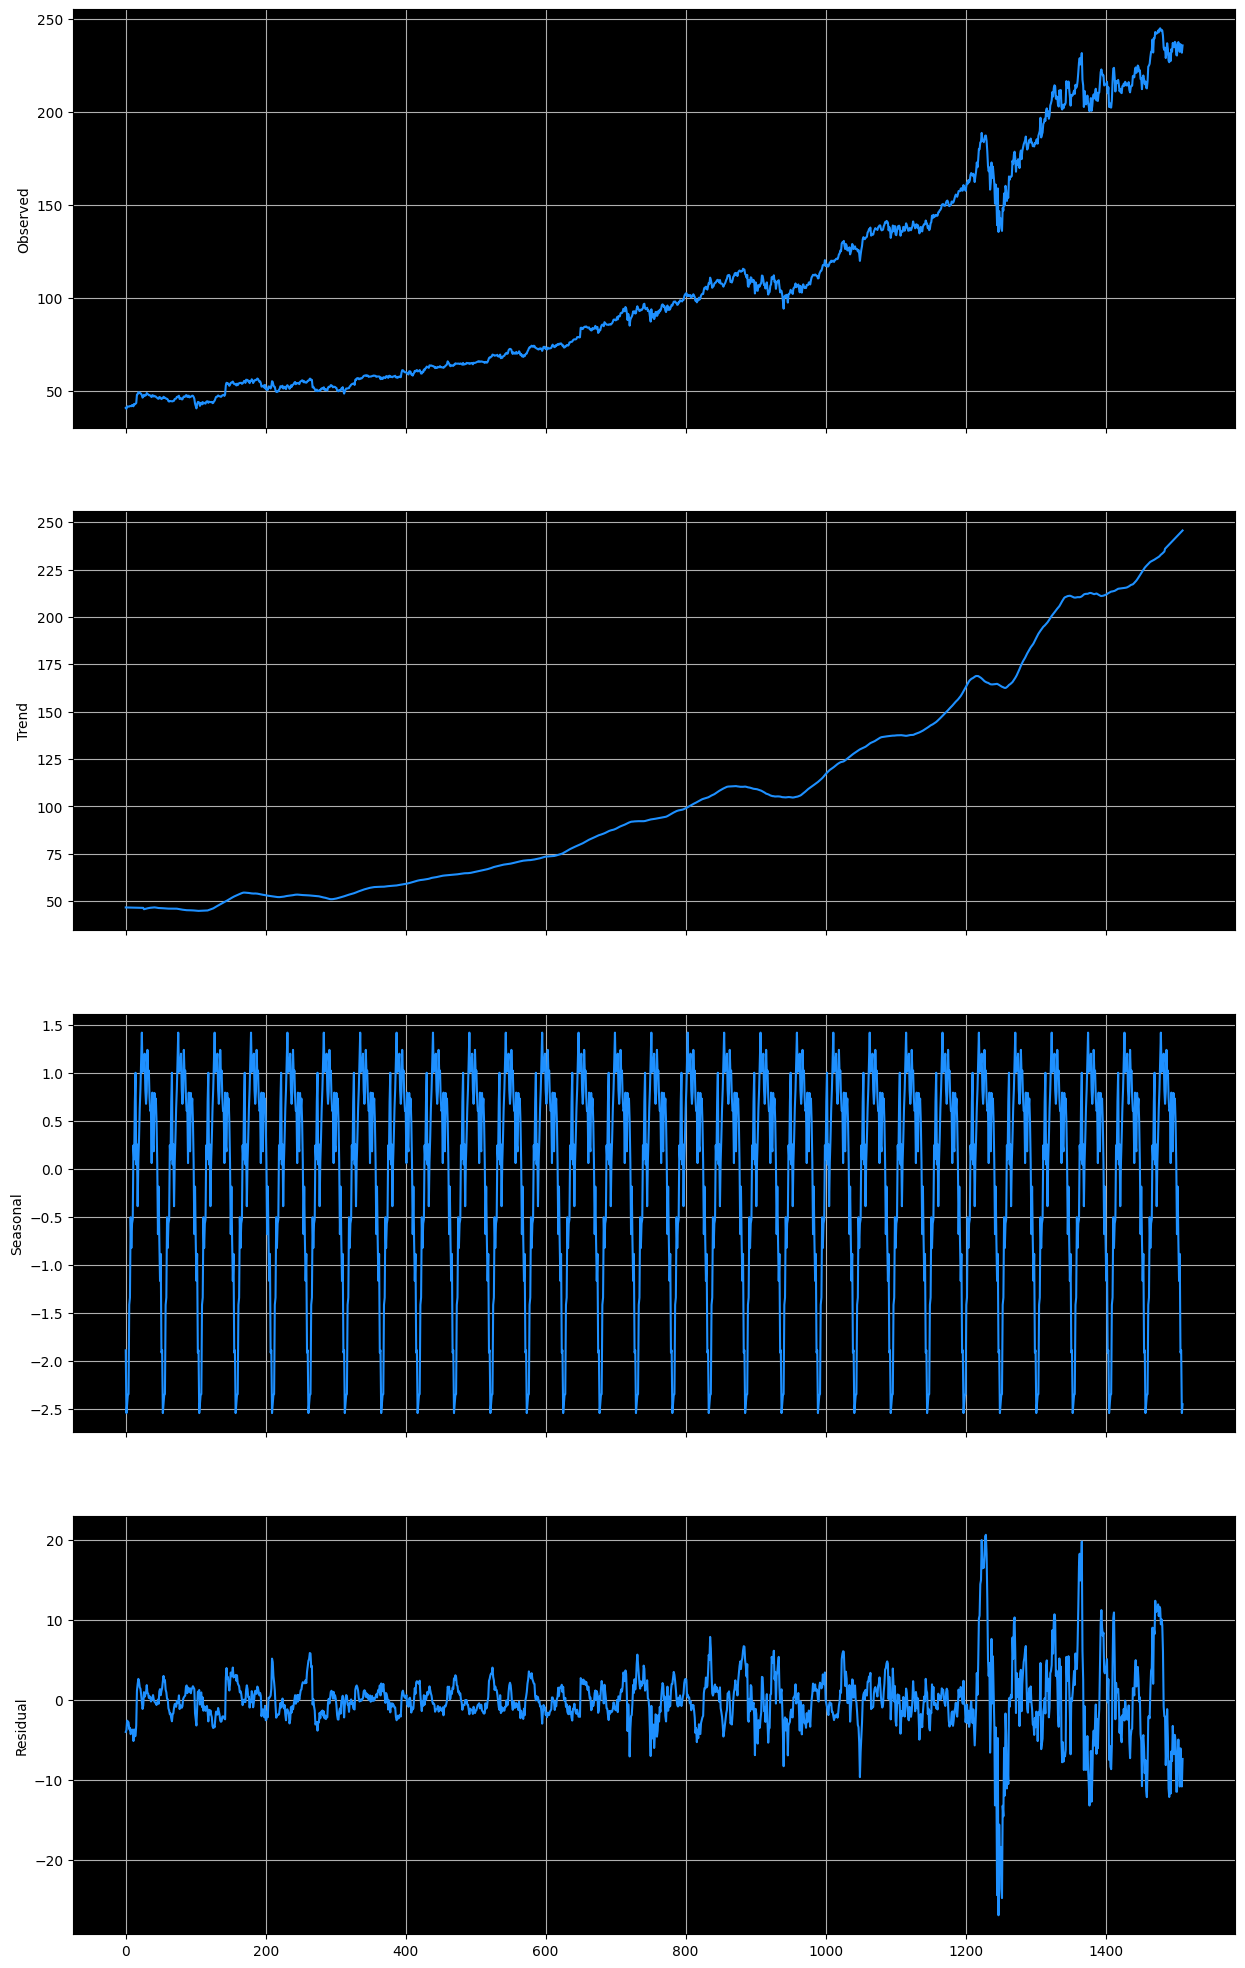

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,25))

res = seasonal_decompose(data['Close'], period=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed')

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend')

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal')

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual')

for a in ax:
  a.set_facecolor('black')
  a.grid(True)

In [ ]:
def make_lags(data, column_name, lags):
  for i in range(1, lags+1):
    lag_column_name = f"{column_name}_shift_{i}"
    data[lag_column_name] = data[column_name].shift(i)

  return data

In [ ]:
make_lags(data, 'Close', 10)

,Date,Open,High,Low,Close,Volume,Close_diff_1,year,month,day,...,Close_shift_1,Close_shift_2,Close_shift_3,Close_shift_4,Close_shift_5,Close_shift_6,Close_shift_7,Close_shift_8,Close_shift_9,Close_shift_10
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322,0.00,2015,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476,-0.43,2015,4,2,...,40.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692,1.26,2015,4,6,...,40.29,40.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375,-0.02,2015,4,7,...,41.55,40.29,40.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438,-0.11,2015,4,8,...,41.53,41.55,40.29,40.72,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853,-3.12,2021,3,25,...,235.46,237.58,235.99,230.35,230.72,237.04,237.71,234.81,235.75,237.13
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853,4.14,2021,3,26,...,232.34,235.46,237.58,235.99,230.35,230.72,237.04,237.71,234.81,235.75
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455,-1.24,2021,3,29,...,236.48,232.34,235.46,237.58,235.99,230.35,230.72,237.04,237.71,234.81
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012,-3.39,2021,3,30,...,235.24,236.48,232.34,235.46,237.58,235.99,230.35,230.72,237.04,237.71


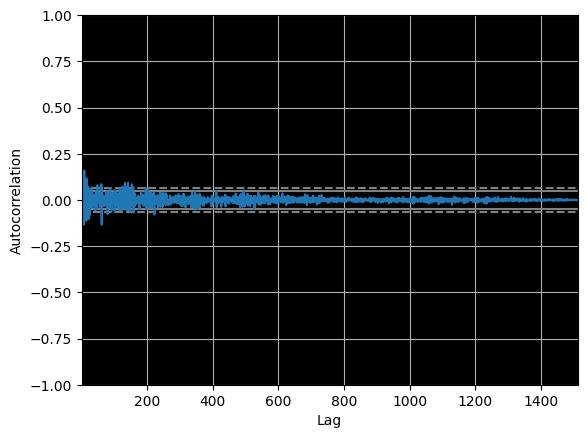

In [ ]:
autocorrelation_plot(data['Close_diff_1'])
plt.gca().set_facecolor('black')
plt.show()

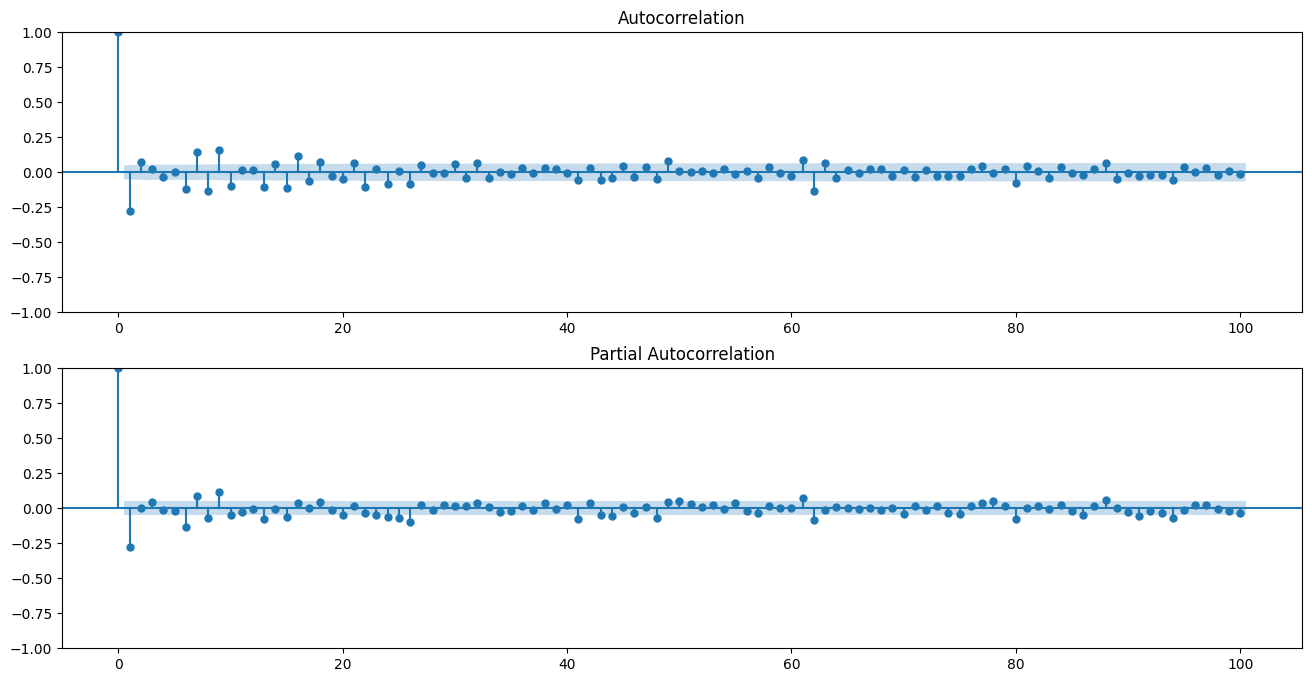

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8))

plot_acf(data['Close_diff_1'], lags=100, ax=ax[0])
plot_pacf(data['Close_diff_1'], lags=100, ax=ax[1])

plt.show()

In [ ]:
train_size = int(0.85*len(data))
test_size = len(data) - train_size

univariate_df = data[['Date', 'Close']].copy()
univariate_df.columns =  ['ds', 'y']

train, test = univariate_df[:train_size], univariate_df[train_size:]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

1284 227


In [ ]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       #use adftest to find optimal 'd'
                      max_p=3, max_q=3, #maximum p and q
                      m=1,              #frequency of series
                      d=None,           #let model determine 'd'
                      seasonal=False,   #No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5252.483, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5416.423, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5251.003, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5270.207, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5418.358, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5252.156, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5188.116, Time=1.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5181.375, Time=2.90 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5238.407, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5182.936, Time=2.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5238.999, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5186.931, Time=1.35 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 10.308 seconds
                               SARIMAX Results                                
Dep. Var

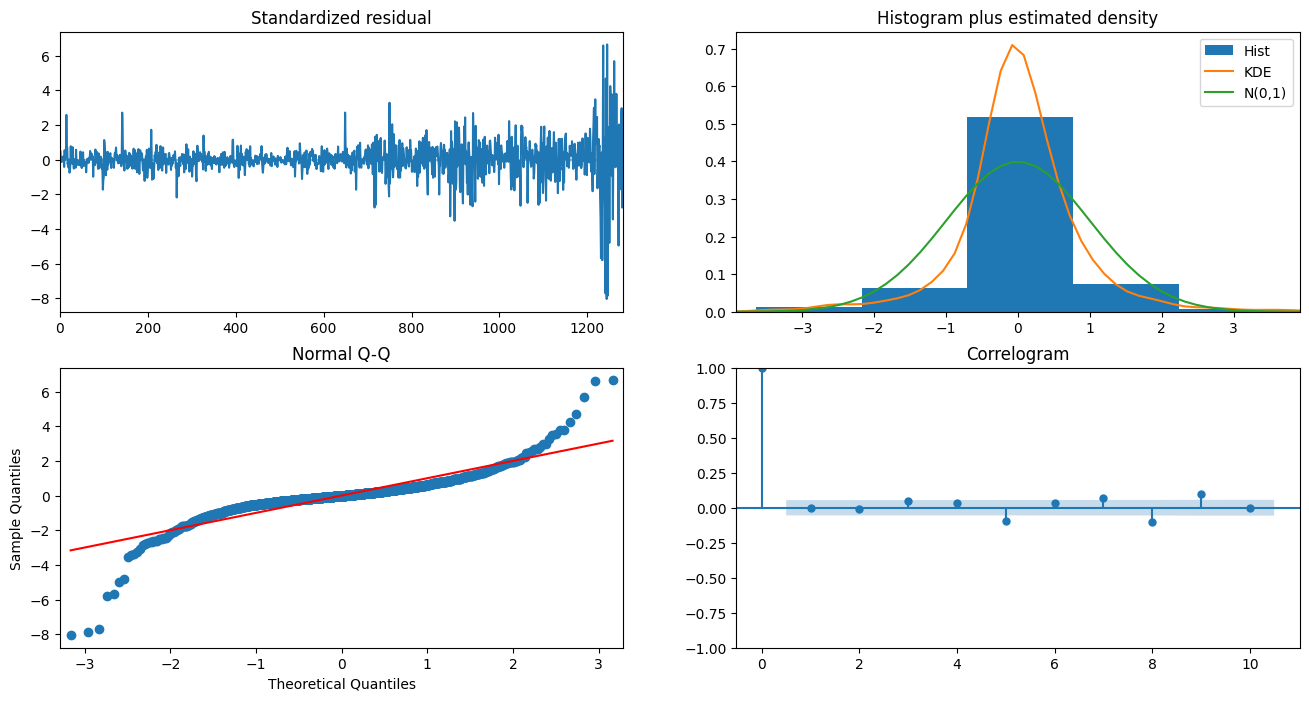

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
import xgboost as xgb

In [ ]:
train.head()

,ds,y
0,2015-04-01 16:00:00,40.72
1,2015-04-02 16:00:00,40.29
2,2015-04-06 16:00:00,41.55
3,2015-04-07 16:00:00,41.53
4,2015-04-08 16:00:00,41.42


In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])

dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.99789936],
       [-1.        ],
       [-0.99384465],
       [-0.99394235],
       [-0.99447973],
       [-0.99418661],
       [-0.99301417],
       [-0.99281876],
       [-0.99335613],
       [-0.99037616]])

In [ ]:
look_back = 52

train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

1180 227


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
1180/1180 [==============================] - 25s 13ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 2/5
1180/1180 [==============================] - 6s 5ms/step - loss: 6.6634e-04 - val_loss: 0.0011
Epoch 3/5
1180/1180 [==============================] - 7s 6ms/step - loss: 6.3192e-04 - val_loss: 0.0011
Epoch 4/5
1180/1180 [==============================] - 6s 5ms/step - loss: 5.3497e-04 - val_loss: 0.0017
Epoch 5/5
1180/1180 [==============================] - 7s 6ms/step - loss: 5.7185e-04 - val_loss: 0.0019
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625  

In [ ]:
y_train.shape

(1180,)

In [ ]:
x_train

array([[[-0.99789936, -1.        , -0.99384465, ..., -0.96995603,
         -0.97225208, -0.97464582]],

       [[-1.        , -0.99384465, -0.99394235, ..., -0.97225208,
         -0.97464582, -0.972936  ]],

       [[-0.99384465, -0.99394235, -0.99447973, ..., -0.97464582,
         -0.972936  , -0.97225208]],

       ...,

       [[-0.46741573, -0.46477772, -0.46438691, ..., -0.29936492,
         -0.2913532 , -0.28216903]],

       [[-0.46477772, -0.46438691, -0.45549585, ..., -0.2913532 ,
         -0.28216903, -0.28192477]],

       [[-0.46438691, -0.45549585, -0.45549585, ..., -0.28216903,
         -0.28192477, -0.29589643]]])

In [1]:
def train_model(data):
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)

  train_predict = scaler.inverse_transform(train_predict)

  test_predict = scaler.inverse_transform(test_predict)

  score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
  score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
  print('RMSE: {}'.format(score_rmse))

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Actual Val')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)

plt.show()

In [ ]:
data_new = pd.read_csv('/content/Microsoft_Stock.csv')
data_new['Date'] = pd.to_datetime(data_new['Date'])

In [ ]:
data_new.head()

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=data_new['Date'], y=data_new['Close'], color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

 FINAL RESULT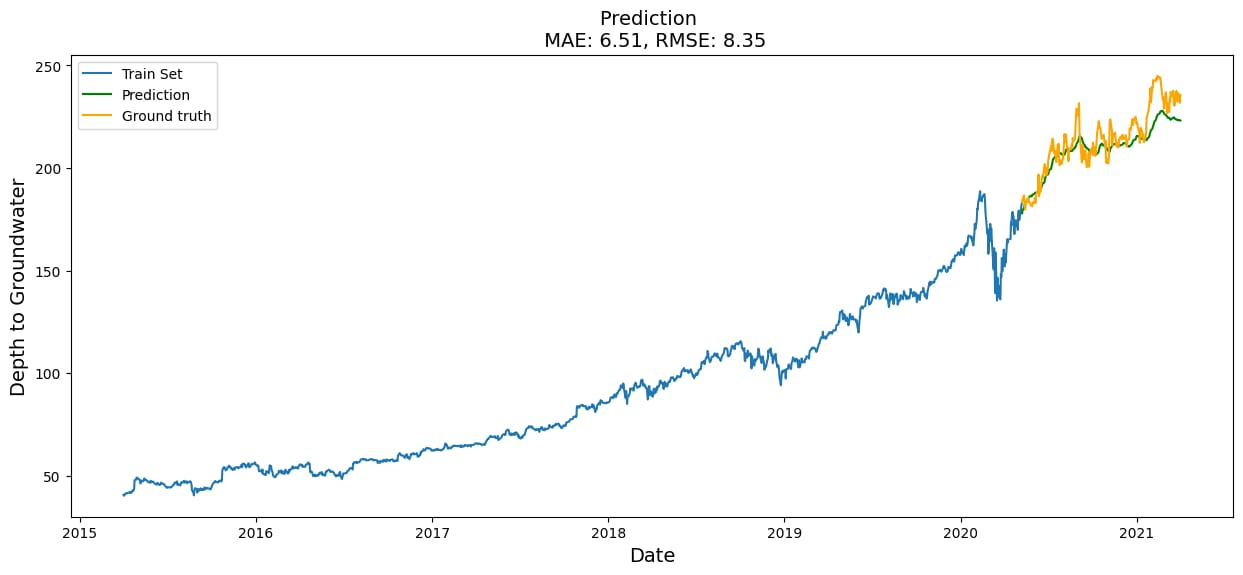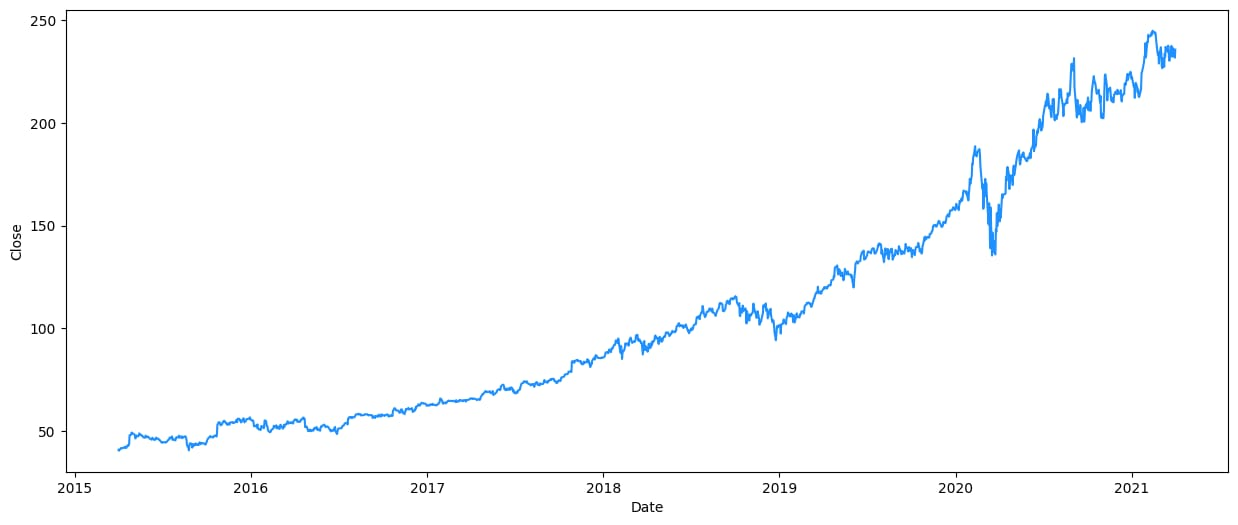